# 02 - Match Flow
Visualiser un match: gold/xp advantage, objectifs, teamfights.

In [1]:
import sys
from pathlib import Path

def _find_root():
    cand = Path.cwd()
    for c in [cand, *cand.parents]:
        if (c / 'src').exists() and (c / 'data').exists():
            return c
    return cand

ROOT = _find_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

processed_dir = ROOT / 'data/processed'
parquet_paths = [processed_dir / f for f in ['matches.parquet', 'players.parquet', 'objectives.parquet', 'teamfights.parquet']]
missing = [p for p in parquet_paths if not p.exists()]
if missing:
    raise FileNotFoundError(f"Parquets manquants: {missing}. Regenerer avec `make parquet`.")

raw_candidates = [ROOT / 'data/raw/data_v2.json', ROOT.parent / 'data/raw/data_v2.json']
raw_path = next((p for p in raw_candidates if p.exists()), None)
if raw_path is None:
    raise FileNotFoundError(f"Raw introuvable pour gold/xp adv. Cherché: {raw_candidates}")

import json
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from src.dota_data import read_processed_tables, objectives_timeline, teamfights_for_match

sns.set_theme(style='whitegrid')

tables = read_processed_tables(processed_dir)
matches = tables['matches']
objectives = tables['objectives']
teamfights = tables['teamfights']

raw = json.loads(raw_path.read_text())
raw_map = {m['json']['match_id']: m['json'] for m in raw}

# Choisir un match (prendre le premier par defaut)
match_id = matches.select('match_id').to_series()[0]
match = raw_map.get(match_id)
if match is None:
    raise KeyError(f"match_id {match_id} non trouvé dans le brut {raw_path}")
match_id


8547022523

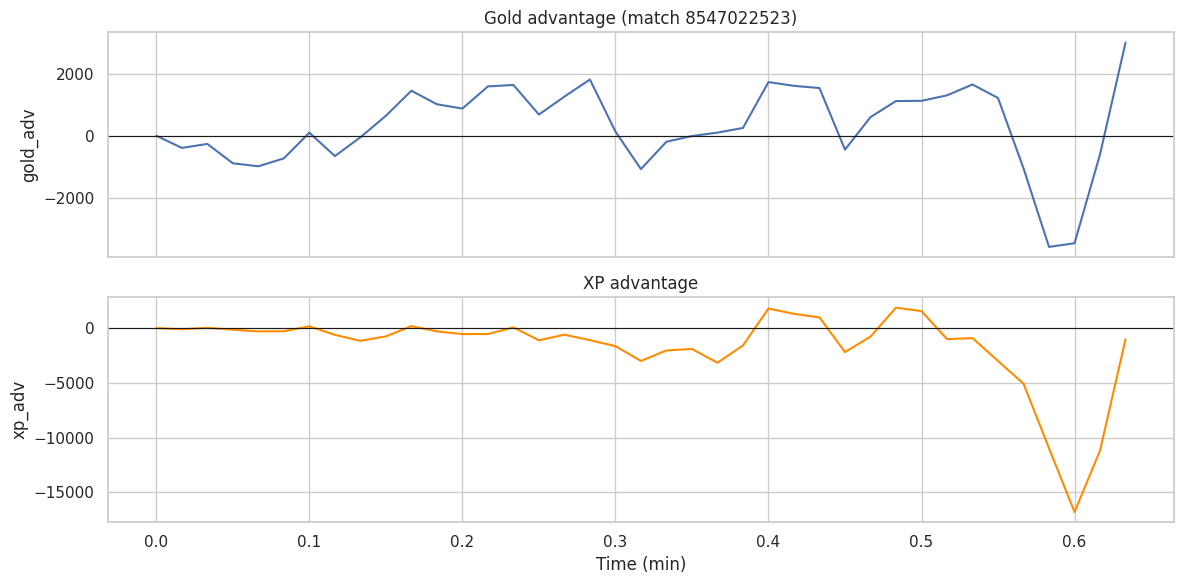

In [2]:
# Gold / XP advantage (radiant perspective)
gold = pd.DataFrame({"time_min": [i/60 for i in range(len(match["radiant_gold_adv"]))],
                    "gold_adv": match["radiant_gold_adv"]})
xp = pd.DataFrame({"time_min": [i/60 for i in range(len(match["radiant_xp_adv"]))],
                  "xp_adv": match["radiant_xp_adv"]})

fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
sns.lineplot(data=gold, x="time_min", y="gold_adv", ax=ax[0])
ax[0].axhline(0, color="k", linewidth=0.8)
ax[0].set_title(f"Gold advantage (match {match_id})")
sns.lineplot(data=xp, x="time_min", y="xp_adv", ax=ax[1], color="darkorange")
ax[1].axhline(0, color="k", linewidth=0.8)
ax[1].set_title("XP advantage")
ax[1].set_xlabel("Time (min)")
plt.tight_layout()
plt.show()

In [3]:
# Winrate global et par patch
winrate = matches.select(pl.col("radiant_win").mean().alias("radiant_winrate"))
winrate_patch = matches.group_by("patch").agg(pl.col("radiant_win").mean().alias("radiant_winrate"))
display(winrate)
display(winrate_patch.sort("patch"))

radiant_winrate
f64
0.500902


patch,radiant_winrate
i64,f64
56,0.501534
57,0.519577
58,0.492989


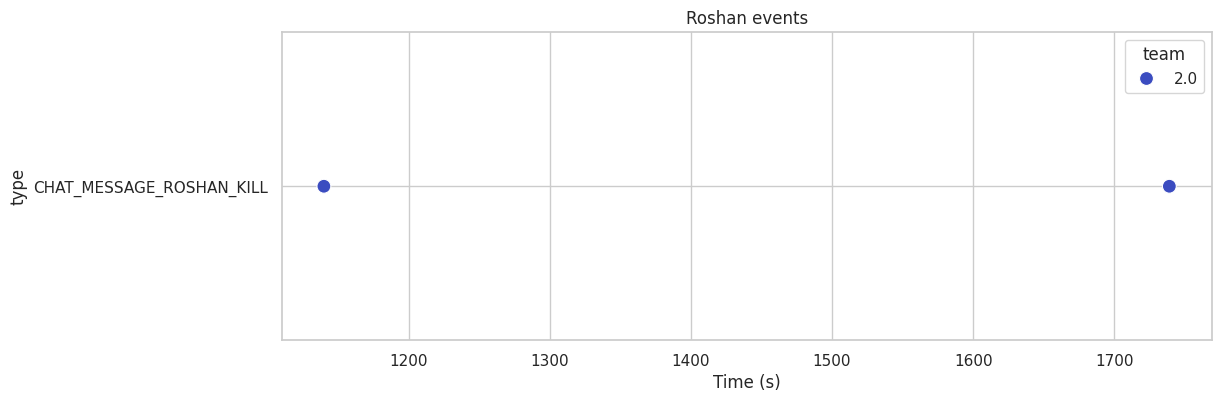

/tmp/ipykernel_1788214/2310240526.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=towers, x="time", y="type", hue="team", palette="viridis", s=60, legend=False)


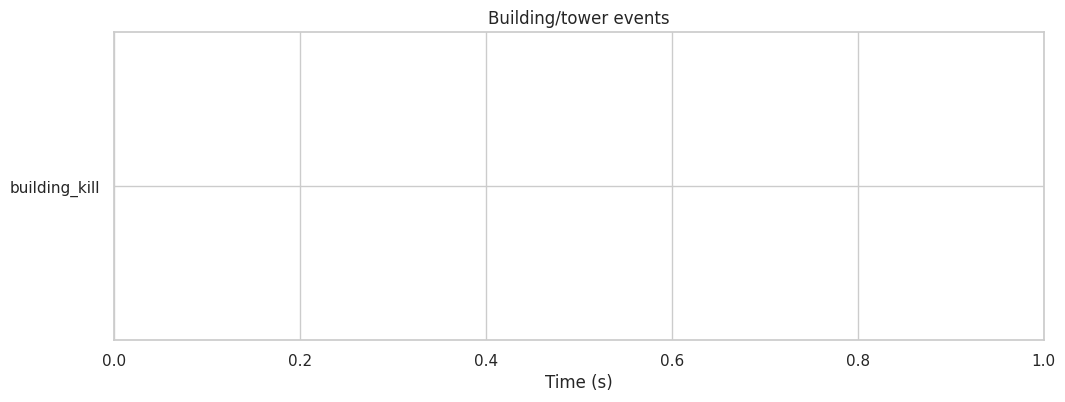

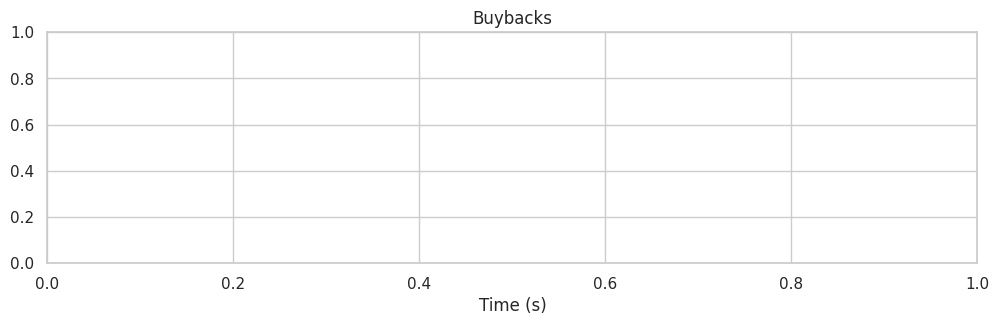

In [4]:
# Timeline des objectifs
objs = objectives_timeline(objectives, match_id).to_pandas()
rosh = objs[objs["type"].str.contains("roshan", case=False, na=False)]
towers = objs[objs["type"].str.contains("tower|building", case=False, na=False)]
buybacks = objs[objs["type"].str.contains("buyback", case=False, na=False)]
plt.figure(figsize=(12,4))
sns.scatterplot(data=rosh, x="time", y="type", hue="team", palette="coolwarm", s=100, legend=True)
plt.title("Roshan events")
plt.xlabel("Time (s)")
plt.show()

plt.figure(figsize=(12,4))
sns.scatterplot(data=towers, x="time", y="type", hue="team", palette="viridis", s=60, legend=False)
plt.title("Building/tower events")
plt.xlabel("Time (s)")
plt.show()

plt.figure(figsize=(12,3))
sns.stripplot(data=buybacks, x="time", y="type", hue="team", dodge=True)
plt.title("Buybacks")
plt.xlabel("Time (s)")
plt.show()

In [5]:
# Teamfights overview
tf = teamfights_for_match(teamfights, match_id).to_pandas()
tf["duration"] = tf["end"] - tf["start"]
tf_summary = tf.groupby("teamfight_index")["duration"].agg(["count", "mean"]).rename(columns={"count": "players", "mean": "avg_duration"})
display(tf_summary.head())

,players,avg_duration
teamfight_index,,
0,10,31.0
1,10,44.0
2,10,53.0
3,10,41.0
